## Work
1. 請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [1]:
import os
import keras
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
def get_result(lr_rate, epo, b_size, momentum, nesterov):
    results = {}
    for lr in lr_rate:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with LR = %.6f" % (lr))
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.SGD(lr=lr, nesterov=nesterov, momentum=momentum)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=epo, 
                  batch_size=b_size, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "exp-lr-%s" % str(lr)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}
    return results


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_result(results):
    color_bar = ["r", "g", "b", "y", "m", "k"]

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.title("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title("Accuracy")
    plt.legend()
    plt.show()

In [8]:
# 設定超參數

LEARNING_RATE = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95

results = get_result(LEARNING_RATE, EPOCHS, BATCH_SIZE, MOMENTUM, True)

Experiment with LR = 0.100000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [============================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.8258 - acc: 0.3463 - val_loss: 1.6436 - val_acc: 0.4096
Epoch 2/50
50000/50000 [==============================] - 3s 67us/step - loss: 1.6004 - acc: 0.4331 - val_loss: 1.5574 - val_acc: 0.4471
Epoch 3/50
50000/50000 [==============================] - 3s 67us/step - loss: 1.5122 - acc: 0.4626 - val_loss: 1.5538 - val_acc: 0.4557
Epoch 4/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.4470 - acc: 0.4863 - val_loss: 1.5390 - val_acc: 0.4458
Epoch 5/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.3991 - acc: 0.5015 - val_loss: 1.4407 - val_acc: 0.4858
Epoch 6/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.3630 - acc: 0.5129 - val_loss: 1.4074 - val_acc: 0.5062
Epoch 7/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.3149 - acc: 0.5304 - val_loss: 1.4195 - val_acc

50000/50000 [==============================] - 3s 65us/step - loss: 1.7991 - acc: 0.3703 - val_loss: 1.7554 - val_acc: 0.3828
Epoch 3/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.7119 - acc: 0.3997 - val_loss: 1.6769 - val_acc: 0.4090
Epoch 4/50
50000/50000 [==============================] - 3s 67us/step - loss: 1.6518 - acc: 0.4211 - val_loss: 1.6352 - val_acc: 0.4233
Epoch 5/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.6033 - acc: 0.4401 - val_loss: 1.5942 - val_acc: 0.4378
Epoch 6/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.5654 - acc: 0.4514 - val_loss: 1.5661 - val_acc: 0.4472
Epoch 7/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.5320 - acc: 0.4648 - val_loss: 1.5554 - val_acc: 0.4493
Epoch 8/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.5043 - acc: 0.4734 - val_loss: 1.5200 - val_acc: 0.4598
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 3s 69us/step - loss: 2.0432 - acc: 0.2953 - val_loss: 2.0094 - val_acc: 0.30247 - acc: 0.295
Epoch 4/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.9822 - acc: 0.3131 - val_loss: 1.9606 - val_acc: 0.3176
Epoch 5/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.9404 - acc: 0.3257 - val_loss: 1.9248 - val_acc: 0.3322
Epoch 6/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.9090 - acc: 0.3354 - val_loss: 1.8978 - val_acc: 0.34121.91
Epoch 7/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.8839 - acc: 0.3454 - val_loss: 1.8759 - val_acc: 0.3470
Epoch 8/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.8626 - acc: 0.3548 - val_loss: 1.8567 - val_acc: 0.3498
Epoch 9/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.8439 - acc: 0.3594 - val_loss: 1.8382 - val_acc: 0.3572
Epoch 10/50
50000/50000 [=========

50000/50000 [==============================] - 3s 64us/step - loss: 2.2479 - acc: 0.1708 - val_loss: 2.2434 - val_acc: 0.1719
Epoch 5/50
50000/50000 [==============================] - 3s 64us/step - loss: 2.2348 - acc: 0.1842 - val_loss: 2.2310 - val_acc: 0.1840
Epoch 6/50
50000/50000 [==============================] - 3s 64us/step - loss: 2.2229 - acc: 0.1945 - val_loss: 2.2197 - val_acc: 0.1950
Epoch 7/50
50000/50000 [==============================] - 3s 64us/step - loss: 2.2119 - acc: 0.2035 - val_loss: 2.2091 - val_acc: 0.2032
Epoch 8/50
50000/50000 [==============================] - 3s 64us/step - loss: 2.2014 - acc: 0.2119 - val_loss: 2.1990 - val_acc: 0.2121
Epoch 9/50
50000/50000 [==============================] - 3s 68us/step - loss: 2.1914 - acc: 0.2194 - val_loss: 2.1891 - val_acc: 0.2189
Epoch 10/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.1817 - acc: 0.2240 - val_loss: 2.1797 - val_acc: 0.2233
Epoch 11/50
50000/50000 [==========================

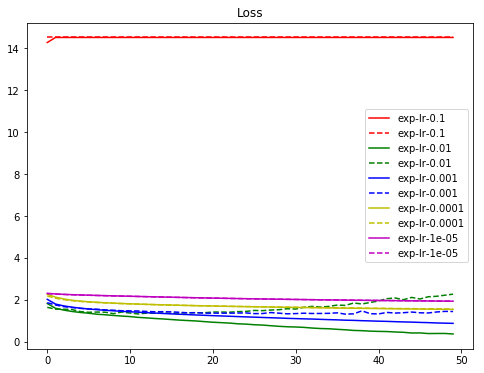

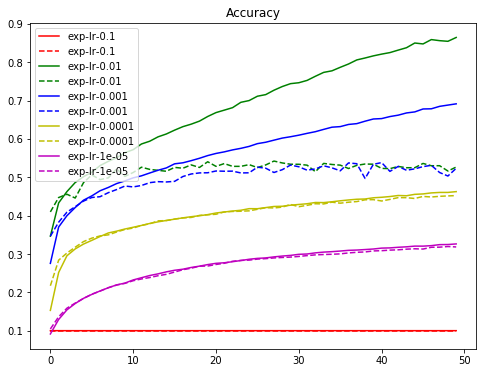

In [9]:
plot_result(results)

In [10]:
# 設定超參數

LEARNING_RATE = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95

results = get_result(LEARNING_RATE, EPOCHS, BATCH_SIZE, MOMENTUM, False)

Experiment with LR = 0.100000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [============================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 69us/step - loss: 1.8735 - acc: 0.3240 - val_loss: 1.6828 - val_acc: 0.4018
Epoch 2/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.6602 - acc: 0.4092 - val_loss: 1.6058 - val_acc: 0.4273
Epoch 3/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.5962 - acc: 0.4298 - val_loss: 1.6046 - val_acc: 0.4301
Epoch 4/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.5296 - acc: 0.4539 - val_loss: 1.4992 - val_acc: 0.4736
Epoch 5/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.4991 - acc: 0.4637 - val_loss: 1.5042 - val_acc: 0.4610
Epoch 6/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.4604 - acc: 0.4762 - val_loss: 1.4660 - val_acc: 0.4824
Epoch 7/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.4239 - acc: 0.4903 - val_loss: 1.4622 - val_acc

50000/50000 [==============================] - 3s 65us/step - loss: 1.8209 - acc: 0.3567 - val_loss: 1.7637 - val_acc: 0.3873
Epoch 3/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.7383 - acc: 0.3863 - val_loss: 1.7009 - val_acc: 0.4065
Epoch 4/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.6887 - acc: 0.4033 - val_loss: 1.6747 - val_acc: 0.4069
Epoch 5/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.6419 - acc: 0.4223 - val_loss: 1.6294 - val_acc: 0.4267
Epoch 6/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.5976 - acc: 0.4366 - val_loss: 1.5901 - val_acc: 0.4417
Epoch 7/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.5628 - acc: 0.4490 - val_loss: 1.5762 - val_acc: 0.4502
Epoch 8/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.5395 - acc: 0.4576 - val_loss: 1.5405 - val_acc: 0.4553
Epoch 9/50
50000/50000 [============================

Epoch 4/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.9900 - acc: 0.3064 - val_loss: 1.9652 - val_acc: 0.3163
Epoch 5/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.9456 - acc: 0.3216 - val_loss: 1.9274 - val_acc: 0.3247
Epoch 6/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.9119 - acc: 0.3316 - val_loss: 1.8986 - val_acc: 0.3320
Epoch 7/50
50000/50000 [==============================] - 3s 68us/step - loss: 1.8856 - acc: 0.3396 - val_loss: 1.8738 - val_acc: 0.3422
Epoch 8/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.8643 - acc: 0.3471 - val_loss: 1.8556 - val_acc: 0.3523
Epoch 9/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.8455 - acc: 0.3533 - val_loss: 1.8392 - val_acc: 0.3535
Epoch 10/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.8298 - acc: 0.3580 - val_loss: 1.8239 - val_acc: 0.3644
Epoch 11/50
50000/50000 [===============

50000/50000 [==============================] - 3s 55us/step - loss: 2.2297 - acc: 0.2058 - val_loss: 2.2242 - val_acc: 0.2127: 2.2303 - acc: 0.20
Epoch 6/50
50000/50000 [==============================] - 3s 55us/step - loss: 2.2156 - acc: 0.2110 - val_loss: 2.2108 - val_acc: 0.2168 - loss: 2.2176 - acc: 0
Epoch 7/50
50000/50000 [==============================] - 3s 55us/step - loss: 2.2023 - acc: 0.2174 - val_loss: 2.1979 - val_acc: 0.2217
Epoch 8/50
50000/50000 [==============================] - 3s 55us/step - loss: 2.1896 - acc: 0.2222 - val_loss: 2.1856 - val_acc: 0.2292
Epoch 9/50
50000/50000 [==============================] - 3s 54us/step - loss: 2.1774 - acc: 0.2277 - val_loss: 2.1740 - val_acc: 0.2340A: 2s - loss: 2.1849 - acc: 0.222 - ETA: 1s - loss: 2.18 - ETA: 1s - loss: 2.1811 - - ETA: 0s - loss: 2.1787 - acc: 0
Epoch 10/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.1658 - acc: 0.2319 - val_loss: 2.1627 - val_acc: 0.2398
Epoch 11/50
50000/50000 [==

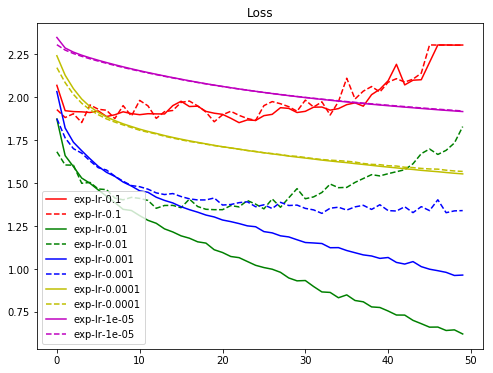

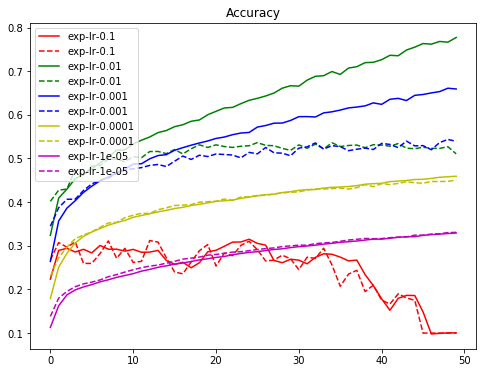

In [11]:
plot_result(results)